In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#acquire
import acquire
import prepare
from env import host, username, password
from pydataset import data
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.cluster import KMeans
from math import sqrt
from scipy import stats


# Acquire & Prep Data

## Acquire data - zillow_data()

In [2]:
df = acquire.zillow_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        223 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77580 non-null  float64
 3   heatingorsystemtypeid         49572 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      207 non-null    float64
 6   airconditioningtypeid         25007 non-null  float64
 7   parcelid                      77580 non-null  int64  
 8   id                            77580 non-null  int64  
 9   logerror                      77580 non-null  float64
 10  transactiondate               77580 non-null  object 
 11  id                            77580 non-null  int64  
 12  basementsqft                  50 non-null     float64
 13  b

## Prep Zillow Data - prepare_zillow()

In [4]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52442
Condominium                                   19342
Duplex (2 Units, Any Combination)              2021
Planned Unit Development                       1947
Quadruplex (4 Units, Any Combination)           729
Triplex (3 Units, Any Combination)              539
Cluster Home                                    335
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       59
Residential General                              42
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

***
Single unit properties - Single Family Residential, Mobile Home, Manufactured, Modular, Prefabricated Homes, Townhouse
* Townhouse only has 6 so drop
***

In [5]:
# Restrict propertylandusedesc to those of single unit
df = df[(df.propertylandusedesc == 'Single Family Residential') | 
        (df.propertylandusedesc == 'Mobile Home') |
        (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes')]

In [6]:
# null values
df.isnull().sum()

typeconstructiontypeid          52499
storytypeid                     52528
propertylandusetypeid               0
heatingorsystemtypeid           18639
buildingclasstypeid             52575
architecturalstyletypeid        52505
airconditioningtypeid           38935
parcelid                            0
id                                  0
logerror                            0
transactiondate                     0
id                                  0
basementsqft                    52528
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18783
calculatedbathnbr                 175
decktypeid                      52183
finishedfloor1squarefeet        48184
calculatedfinishedsquarefeet      102
finishedsquarefeet12              309
finishedsquarefeet13            52533
finishedsquarefeet15            52575
finishedsquarefeet50            48184
finishedsquarefeet6             52410
fips                                0
fireplacecnt

In [7]:
# dropping cols/rows where more than half of the values are null
df = prepare.handle_missing_values(df, col_perc = .5, row_perc = .5)

In [8]:
# dropping the columns with 17K missing values too much to fill/impute/drop rows
df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])

In [9]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

In [10]:
# single outlier in transactiondate
df.transactiondate.sort_values(ascending=False)

77579    2018-05-25
77578    2017-09-25
77577    2017-09-21
77576    2017-09-21
77575    2017-09-20
            ...    
7        2017-01-01
6        2017-01-01
3        2017-01-01
2        2017-01-01
0        2017-01-01
Name: transactiondate, Length: 52575, dtype: object

In [11]:
df.transactiondate.describe()

count          52575
unique           258
top       2017-06-30
freq             814
Name: transactiondate, dtype: object

In [12]:
# address date outlier by replacing with mode
df['transactiondate'] = df.transactiondate.replace('2018-05-25', '2017-06-30')

In [13]:
# Convert transactiondate to datetime
df['transactiondate'] = pd.to_datetime(df.transactiondate)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52575 entries, 0 to 77579
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   propertylandusetypeid         52575 non-null  float64       
 1   parcelid                      52575 non-null  int64         
 2   id                            52575 non-null  int64         
 3   logerror                      52575 non-null  float64       
 4   transactiondate               52575 non-null  datetime64[ns]
 5   id                            52575 non-null  int64         
 6   bathroomcnt                   52575 non-null  float64       
 7   bedroomcnt                    52575 non-null  float64       
 8   calculatedbathnbr             52400 non-null  float64       
 9   calculatedfinishedsquarefeet  52473 non-null  float64       
 10  finishedsquarefeet12          52266 non-null  float64       
 11  fips                        

In [14]:
# drop assessment year as it is one single year
df = df.drop(columns=(['assessmentyear']))

In [15]:
#dropping the id columns, as parcelid is a unique identifier
df= df.drop(columns=('id'))

In [16]:
df.isnull().sum()

propertylandusetypeid              0
parcelid                           0
logerror                           0
transactiondate                    0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                175
calculatedfinishedsquarefeet     102
finishedsquarefeet12             309
fips                               0
fullbathcnt                      175
latitude                           0
longitude                          0
lotsizesquarefeet                375
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1037
regionidcounty                     0
regionidzip                       27
roomcnt                            0
yearbuilt                        135
structuretaxvaluedollarcnt        96
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              2
taxamount                          4
censustractandblock              123
propertylandusedesc                0
d

***
#### prepare.prep_zillow() executes all of the above operations

def prep_zillow(df):
    
    ''' Single Unit Properties excluding shared structures'''
    # Restrict propertylandusedesc to those of single unit
    df = df[(df.propertylandusedesc == 'Single Family Residential') |
            (df.propertylandusedesc == 'Mobile Home') |
          (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes')]
    
    # remove outliers in bed count, bath count, and area to better target single unit properties
    df = remove_outliers(df, 1.5, ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt'])
    
    # dropping cols/rows where more than half of the values are null
    df = handle_missing_values(df, col_perc = .5, row_perc = .5)
    
    # dropping the columns with 17K missing values; too much to fill/impute/drop rows
    df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])
    
    ##### transactiondate outlier #### 
    
    # address date outlier by replacing with mode
    df['transactiondate'] = df.transactiondate.replace('2018-05-25', '2017-06-30')
    
    # Convert transactiondate to datetime
    df['transactiondate'] = pd.to_datetime(df.transactiondate)
    
    # drop assessment year as it is one single year
    df = df.drop(columns=(['assessmentyear']))
    
    #dropping the id columns, as parcelid is a unique identifier
    df= df.drop(columns=('id'))
    
    # Convert logerror to absolute value
    df['logerror'] = df.logerror.abs()
    
    return df
***

### FIPS data manipulation

In [17]:
# convert fips to integer to drop decimals before converting to string
df['fips'] = df['fips'].astype(int)

In [18]:
# convert fips data to string so that we can split
df['fips'] = df['fips'].astype('str')

In [19]:
# confirm
df.fips.dtype

dtype('O')

In [20]:
# Create County column by stripping state reference location(last three digits)
df['county'] = df['fips'].str[1:]

In [21]:
# check to see how many different counties
df.county.value_counts()

037    33966
059    14145
111     4464
Name: county, dtype: int64

In [22]:
# Replace numerics with labels
df['county'] = df['county'].replace({'037':'Los Angeles', '059':'Orange', '111':'Ventura'})

In [23]:
# control check on manipulation
df.county.value_counts()

Los Angeles    33966
Orange         14145
Ventura         4464
Name: county, dtype: int64

***
#### prepare.fips_county() executes all of the above operations

def fips_county(df):

    '''referencing FIPS data to create a county feature'''
    # convert fips to integer to drop decimals before converting to string
    df['fips'] = df['fips'].astype(int)
    # convert fips data to string so that we can split
    df['fips'] = df['fips'].astype('str')
    # Create County column by stripping state reference location(last three digits)
    df['county'] = df['fips'].str[1:]
    # Replace numerics with labels
    df['county'] = df['county'].replace({'037':'Los Angeles', '059':'Orange', '111':'Ventura'})
    
    return df
 ***

***
#### Notes on fips:
* fips codes in zillow data missing the leading zero for the state code first two digit assignment.  Only reason discovered this was by looking up standard fips codes are 5 digit...data only provides 
* first 2 numerics = state, last 3 numerics = county
* only 1 state code and 3 county codes in zillow dataframe

look up code references and construct new columns identifying state and counties (source: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)
* State codes: 01 = CA
* County codes: 037=Los Angeles County, 059=Orange County & 111=Ventura County 
***

### Calculate Tax Rate

In [24]:
df['tax_rate'] = round((df.taxamount / df.taxvaluedollarcnt), 3)

In [25]:
df.tax_rate.describe()

count    52570.000000
mean         0.013352
std          0.006677
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.816000
Name: tax_rate, dtype: float64

In [26]:
df.tax_rate.sort_values(ascending=False).head(10)

62060    0.816
73329    0.494
45856    0.453
8711     0.346
33148    0.295
36626    0.278
43099    0.204
39641    0.183
77506    0.179
43970    0.148
Name: tax_rate, dtype: float64

In [27]:
# drop the rows with tax rates in excess of 0.2
df = df.drop(df[df['tax_rate']>0.2].index)

In [28]:
df.tax_rate.describe()

count    52563.000000
mean         0.013299
std          0.004314
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.183000
Name: tax_rate, dtype: float64

***
#### prepare.taxrate_calc(df) executes above operations

def taxrate_calc(df)   

    df['tax_rate'] = round((df.taxamount / df.taxvaluedollarcnt), 3)
    # drop the rows with tax rates in excess of 0.2
    df = df.drop(df[df['tax_rate']>0.2].index)
    
    return df
***

***
#### Notes on Tax Rate: Now that we have a calculated tax_rate should be easier to detect outliers
* no negative values 
* max didn't pass the smell test.  While some of the calculated tax rates seemed high, there were 3 in particular that stuck out at 45%, 49% & 81%. While other values did appear off, I decided to only cut these two as they were completely in a dimension of their own.
***

In [29]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'tax_rate']

In [31]:
# Split data
train, validate, test = prepare.split_continuous(df)

train -> (29437, 29)
validate -> (12617, 29)
test -> (10514, 29)


In [32]:
# impute mode on discrete columns in split data
imputer = SimpleImputer(strategy='most_frequent')
train[discrete_col] = imputer.fit_transform(train[discrete_col])
validate[discrete_col] = imputer.transform(validate[discrete_col])
test[discrete_col] = imputer.transform(test[discrete_col])

In [33]:
# impute mean on continuous columns in split data
imputer = SimpleImputer(strategy='mean')
train[cont_col] = imputer.fit_transform(train[cont_col])
validate[cont_col] = imputer.transform(validate[cont_col])
test[cont_col] = imputer.transform(test[cont_col])

In [34]:
#control test
test.isnull().sum()

propertylandusetypeid           0
parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandusedesc             0
county                          0
tax_rate                        0
dtype: int64

### Control check to make sure we've addressed nulls

In [35]:
train.isnull().sum()

propertylandusetypeid           0
parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandusedesc             0
county                          0
tax_rate                        0
dtype: int64

In [36]:
train.shape, validate.shape, test.shape

((29437, 29), (12617, 29), (10514, 29))

***
#### prepare.data_split_impute(df) performs above operations

def data_split_impute(df)
    
    '''organize features and split data into train, validate and test and impute missing observations'''
    
    # Organize Discrete & Continous features
    discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
    cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
    
    # Split data
    train, validate, test = split_continuous(df)
    
    # impute mode on discrete columns in split data
    imputer = SimpleImputer(strategy='most_frequent')
    train[discrete_col] = imputer.fit_transform(train[discrete_col])
    validate[discrete_col] = imputer.transform(validate[discrete_col])
    test[discrete_col] = imputer.transform(test[discrete_col])
    
    # impute mean on continuous columns in split data
    imputer = SimpleImputer(strategy='mean')
    train[cont_col] = imputer.fit_transform(train[cont_col])
    validate[cont_col] = imputer.transform(validate[cont_col])
    test[cont_col] = imputer.transform(test[cont_col])
    
    return train, validate, test
***

### Review collinearity amongst independent variables

In [37]:
# Separate variables by associations, adding in target
sqft = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12']
bath = ['bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'calculatedbathnbr']
value = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
loc = ['latitude', 'longitude', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'censustractandblock']

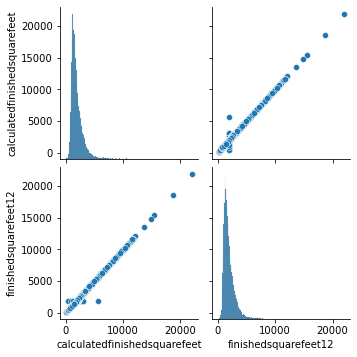

In [38]:
sns.pairplot(data = train[sqft])

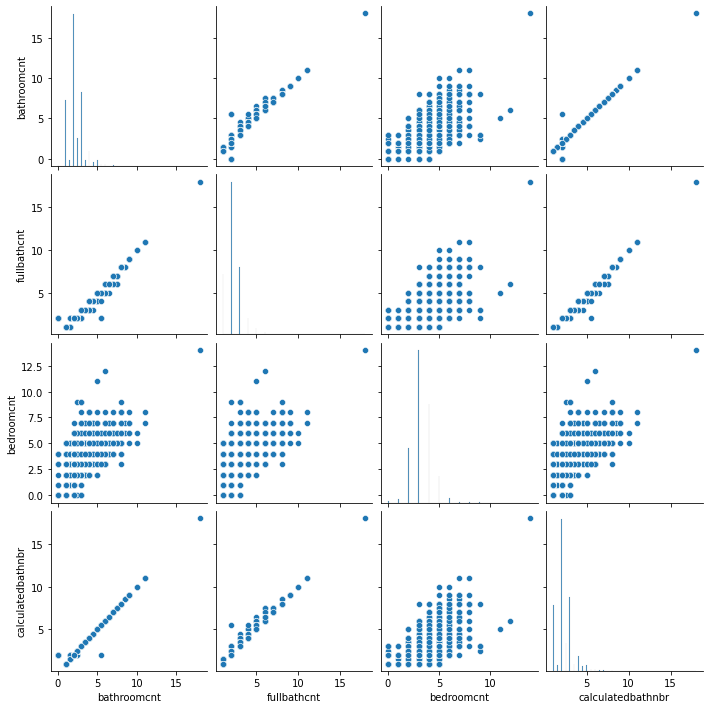

In [39]:
sns.pairplot(data = train[bath])

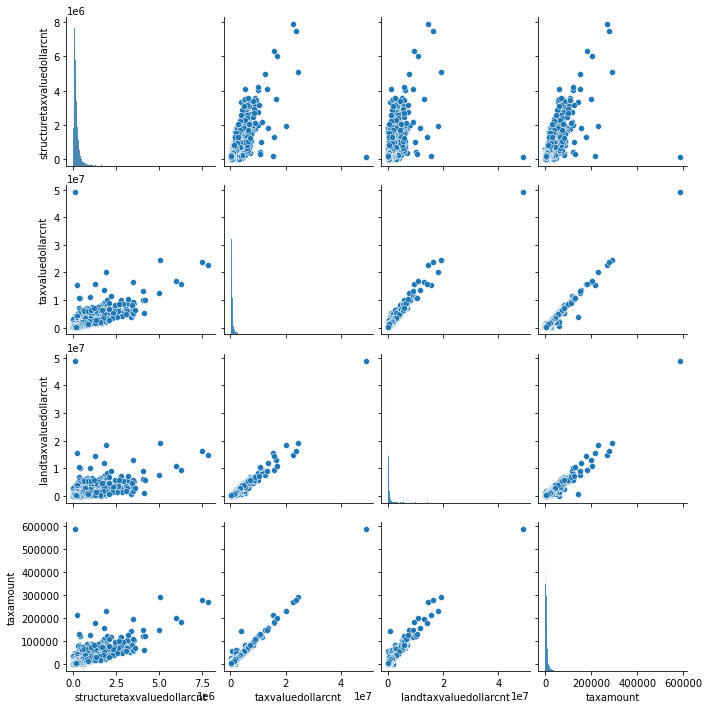

In [40]:
sns.pairplot(data = train[value])

In [41]:
train[sqft].corr()

,calculatedfinishedsquarefeet,finishedsquarefeet12
calculatedfinishedsquarefeet,1.000000,0.998194
finishedsquarefeet12,0.998194,1.000000


In [42]:
train[bath].corr()

,bathroomcnt,fullbathcnt,bedroomcnt,calculatedbathnbr
bathroomcnt,1.000000,0.979490,0.652559,0.993995
fullbathcnt,0.979490,1.000000,0.629637,0.985724
bedroomcnt,0.652559,0.629637,1.000000,0.638486
calculatedbathnbr,0.993995,0.985724,0.638486,1.000000


In [43]:
train[value].corr()

,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
structuretaxvaluedollarcnt,1.000000,0.778119,0.587853,0.776153
taxvaluedollarcnt,0.778119,1.000000,0.965479,0.990652
landtaxvaluedollarcnt,0.587853,0.965479,1.000000,0.954369
taxamount,0.776153,0.990652,0.954369,1.000000


In [44]:
train[loc].corr()

,latitude,longitude,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,censustractandblock
latitude,1.000000,-0.546242,-0.063137,-0.018695,0.589190,0.013241,-0.008679
longitude,-0.546242,1.000000,-0.373804,0.003727,-0.372993,0.028576,-0.029205
rawcensustractandblock,-0.063137,-0.373804,1.000000,-0.036745,-0.598863,0.028576,0.081234
regionidcity,-0.018695,0.003727,-0.036745,1.000000,0.058236,-0.011613,-0.005775
regionidcounty,0.589190,-0.372993,-0.598863,0.058236,1.000000,-0.035269,-0.046451
regionidzip,0.013241,0.028576,0.028576,-0.011613,-0.035269,1.000000,0.001922
censustractandblock,-0.008679,-0.029205,0.081234,-0.005775,-0.046451,0.001922,1.000000


In [45]:
train.censustractandblock.nunique()

20987

In [46]:
# drop corrlated columns from split data
train = train.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))
validate = validate.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))
test = test.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))

In [47]:
print(train.shape, validate.shape, test.shape)

(29437, 24) (12617, 24) (10514, 24)


***
#### Key Takeaways: 

* calculatedfinishedsquarefeet & finishedsquarefeet12 highly correlated 
    * drop finishedsquarefeet12  
* calculatedbathnbr hihgly correlated with bathroomcnt less so with bedroomcnt
    * going to drop all except bathroomcnt & bedroomcnt 
* taxvaluedollarcount highly correlated with all others in this group     
    * correlation b/w taxvaluedollarcnt & structuretaxvaluedollarcnt weaker, keep these two and drop others       
* Not able to deal w/location features using correlation
       
***

# Feature Engineering

In [48]:
train.corr().sort_values('logerror', ascending=False)

,propertylandusetypeid,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,censustractandblock,tax_rate
logerror,0.003194,0.004595,1.000000,0.040762,0.045072,0.043204,-0.016416,0.019903,0.006122,0.010129,0.007965,-0.024488,-0.002900,0.014873,0.021951,0.007747,0.008560,0.006347,0.010027
bedroomcnt,-0.079040,0.060784,0.045072,0.652559,1.000000,0.626006,0.016732,-0.005368,0.004910,0.125837,-0.040371,-0.131293,0.024992,0.169464,0.379810,0.375172,0.273278,0.014969,-0.077647
calculatedfinishedsquarefeet,-0.015048,0.052873,0.043204,0.847356,0.626006,1.000000,-0.036447,-0.008276,0.037312,0.105164,-0.044948,-0.133624,0.034099,0.072213,0.449450,0.752268,0.598464,0.006060,-0.143388
bathroomcnt,-0.042916,0.048407,0.040762,1.000000,0.652559,0.847356,-0.010969,-0.003039,0.024829,0.099185,-0.048220,-0.135124,0.031991,0.071039,0.516856,0.642091,0.505837,0.006685,-0.137847
yearbuilt,0.025654,0.165388,0.021951,0.516856,0.379810,0.449450,0.048475,0.094059,0.037453,0.296927,-0.078809,-0.344691,0.050279,0.186657,1.000000,0.339017,0.155719,0.027211,-0.048375
longitude,-0.080285,-0.051088,0.019903,-0.003039,-0.005368,-0.008276,-0.546242,1.000000,-0.015485,-0.373804,0.003727,-0.372993,0.028576,-0.017941,0.094059,-0.057281,-0.036214,-0.029205,0.012958
roomcnt,0.000585,0.372083,0.014873,0.071039,0.169464,0.072213,-0.286899,-0.017941,-0.013703,0.737208,-0.043305,-0.748886,0.027675,1.000000,0.186657,-0.048209,-0.015156,0.058954,-0.186389
rawcensustractandblock,0.096182,0.467099,0.010129,0.099185,0.125837,0.105164,-0.063137,-0.373804,-0.005693,1.000000,-0.036745,-0.598863,0.028576,0.737208,0.296927,0.058363,0.013550,0.081234,-0.180783
tax_rate,-0.015902,-0.064724,0.010027,-0.137847,-0.077647,-0.143388,0.225116,0.012958,-0.010554,-0.180783,0.001780,0.214048,-0.004367,-0.186389,-0.048375,-0.157105,-0.184715,-0.018550,1.000000
taxvaluedollarcnt,-0.017369,0.003685,0.008560,0.505837,0.273278,0.598464,-0.112368,-0.036214,0.020201,0.013550,-0.023701,-0.049483,0.027974,-0.015156,0.155719,0.778119,1.000000,0.001847,-0.184715


***
Key Takeaways: 
* Location matters: longitude, latitude and County appear to correlated to logerror
* Value matters: taxdollarcnt has 2nd strongest correlations
* Size matters most: calculatedsquarefeet, bedroomcnt & bathrmcnt have the strongest correlations with logerror
    * create new feature bedroomcnt and bathrmcnt per sq ft
* Year built most significant factor
***

### Create new features using calculatedfinishedsquarefeet

In [49]:
# combine sqft with highly correlated features in order to eliminate noise
train['bedsqft'] = train.bedroomcnt/train.calculatedfinishedsquarefeet
train['bathsqft'] = train.bathroomcnt/train.calculatedfinishedsquarefeet
train['pricesqft'] = train.taxvaluedollarcnt/train.calculatedfinishedsquarefeet
validate['bedsqft'] = validate.bedroomcnt/validate.calculatedfinishedsquarefeet
validate['bathsqft'] = validate.bathroomcnt/validate.calculatedfinishedsquarefeet
validate['pricesqft'] = validate.taxvaluedollarcnt/validate.calculatedfinishedsquarefeet
test['bedsqft'] = test.bedroomcnt/test.calculatedfinishedsquarefeet
test['bathsqft'] = test.bathroomcnt/test.calculatedfinishedsquarefeet
test['pricesqft'] = test.taxvaluedollarcnt/test.calculatedfinishedsquarefeet

### Bin logerror into quartiles

In [50]:
# Create log quartile column to separate logerror extremes and identify trends
log_quantile = [1,2,3,4]
train['log_quartile'] = pd.qcut(train['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)
validate['log_quartile'] = pd.qcut(validate['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)
test['log_quartile'] = pd.qcut(test['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)

### Divide taxvaluedollarcnt into General Market & Premium market

In [51]:
# Evaluate and break housing data into general and premium market
train.taxvaluedollarcnt.describe()

count    2.943700e+04
mean     5.310097e+05
std      7.842343e+05
min      1.108900e+04
25%      1.927000e+05
50%      3.743700e+05
75%      6.200000e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64

In [52]:
# First 3 quartiles
train.logerror[train['taxvaluedollarcnt']<620000].describe()

count    22069.000000
mean         0.019670
std          0.167660
min         -2.330162
25%         -0.024397
50%          0.006316
75%          0.038560
max          3.100913
Name: logerror, dtype: float64

In [53]:
# Last quartile
train.logerror[train['taxvaluedollarcnt']>620000].describe()

count    7358.000000
mean        0.020979
std         0.216309
min        -2.406257
25%        -0.021649
50%         0.011946
75%         0.049946
max         5.262999
Name: logerror, dtype: float64

In [54]:
# Create Boolean Column for general market = <620000 which covers first 3 quartiles
train['value_generalmkt'] = train['taxvaluedollarcnt']<620000
validate['value_generalmkt'] = validate['taxvaluedollarcnt']<620000
test['value_generalmkt'] = test['taxvaluedollarcnt']<620000

In [55]:
# Convert Bools into 1 & 0
train['value_generalmkt'] = train.value_generalmkt.replace({False:0, True:1})
validate['value_generalmkt'] = validate.value_generalmkt.replace({False:0, True:1})
test['value_generalmkt'] = test.value_generalmkt.replace({False:0, True:1})

In [56]:
validate.value_generalmkt.head()

43877    1
53884    1
39110    0
63303    1
28522    1
Name: value_generalmkt, dtype: int64

## Scale data

#### Columns to scale

In [124]:
train.columns

Index(['propertylandusetypeid', 'parcelid', 'logerror', 'transactiondate',
       'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'censustractandblock', 'propertylandusedesc', 'county', 'tax_rate',
       'bedsqft', 'bathsqft', 'pricesqft', 'log_quartile', 'value_generalmkt',
       'age'],
      dtype='object')

In [125]:
cols_to_scale = ['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'taxvaluedollarcnt', 'tax_rate', 'bedsqft', 'bathsqft', 'pricesqft', 'age']

#### Convert yearbuilt to age in order to scale

In [126]:
train['age'] = 2017 - train.yearbuilt
validate['age'] = 2017 - validate.yearbuilt
test['age'] = 2017 - test.yearbuilt

In [127]:
### Min Max Scaler 
train_scaled, validate_scaled, test_scaled = prepare.min_max_scale(train, validate, test, cols_to_scale)

In [128]:
# Control Test
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((29437, 9), (12617, 9), (10514, 9))

#### Concat scaled data w/explored features

In [129]:
# Concat log_quartile & value_generalmkt to scaled data
train_scaled = pd.concat((train_scaled, train[['logerror', 'log_quartile', 'value_generalmkt', 'county']]), axis=1)
validate_scaled = pd.concat((validate_scaled, validate[['logerror', 'log_quartile', 'value_generalmkt', 'county']]), axis=1)
test_scaled = pd.concat((test_scaled, test[['logerror', 'log_quartile', 'value_generalmkt', 'county']]), axis=1)

In [130]:
# replace county name with numbers
train_scaled['county'] = train_scaled.county.replace({'Ventura':0, 'Los Angeles':1, 'Orange':2})
validate_scaled['county'] = validate_scaled.county.replace({'Ventura':0, 'Los Angeles':1, 'Orange':2})
test_scaled['county'] = test_scaled.county.replace({'Ventura':0, 'Los Angeles':1, 'Orange':2})

In [131]:
# Control Test
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((29437, 13), (12617, 13), (10514, 13))

In [132]:
train_scaled.head()

,calculatedfinishedsquarefeet,latitude,longitude,taxvaluedollarcnt,tax_rate,bedsqft,bathsqft,pricesqft,age,logerror,log_quartile,value_generalmkt,county
50879,0.138847,0.378028,0.554638,0.052865,0.076923,0.048177,0.096355,0.110883,0.117647,0.027787,3,0,1
46325,0.123481,0.483849,0.838983,0.020666,0.083916,0.043121,0.134752,0.048234,0.477941,0.260666,4,0,1
23345,0.081510,0.403236,0.803119,0.010885,0.076923,0.031916,0.079790,0.037751,0.448529,0.041198,3,1,2
76829,0.039173,0.837494,0.713354,0.001263,0.167832,0.092872,0.077393,0.009044,0.470588,-0.036637,1,1,1
59344,0.085868,0.144420,0.921849,0.013911,0.069930,0.045600,0.076000,0.045971,0.264706,-0.014228,2,0,2


# Explore

## Longitude/Latitude by distribution of logerror & yearbuilt

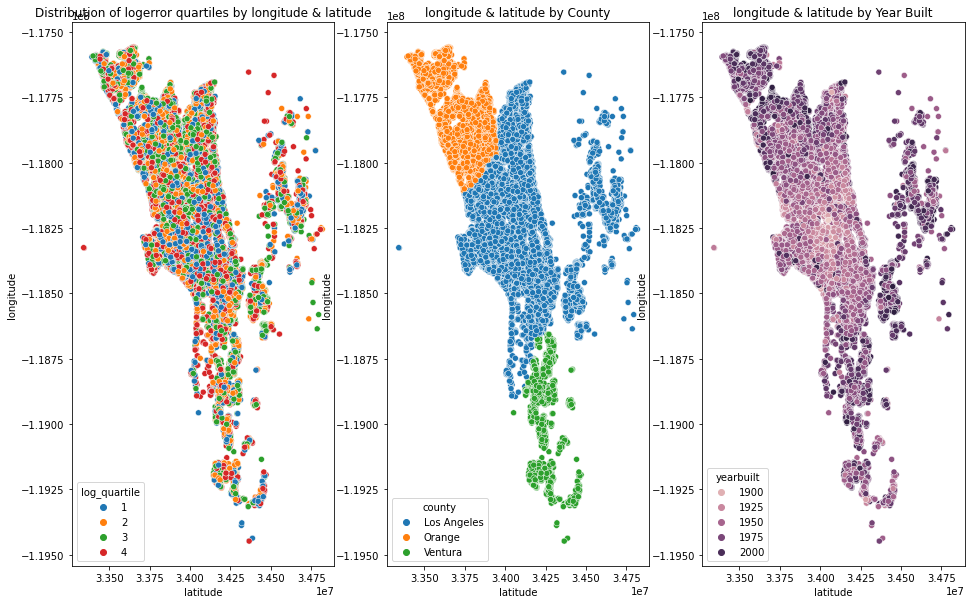

In [133]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.log_quartile)
plt.title('Distribution of logerror quartiles by longitude & latitude')
plt.subplot(132)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.county)
plt.title('longitude & latitude by County')
plt.subplot(133)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.yearbuilt)
plt.title('longitude & latitude by Year Built')
plt.show()

***
Key Takeaways: 
* By binning the logerror we can see where the biggest misses (1st & 4th) quartile are located
    * There are some groupings we can pick up with the 4th quartile worth exploring
        * coastal areas, some pockets but not very easy to see optically
    * However, a strong grouping of 1st quartile logerror is obvious in the belly of Los Angeles County extending all the way to its southern edge
    * Logerrors in Orange County appear equally distributed with the exception of its coastal area
    * Logerrors in Ventura County appear minimal with except of its Southwestern-most point
* There appears to be some clear association b/w logerror and yearbuilt
***

## Distribution of logerror across logerror and bed/bath sqft ratios, yearbuilt & county, acrosss tax_rate & County

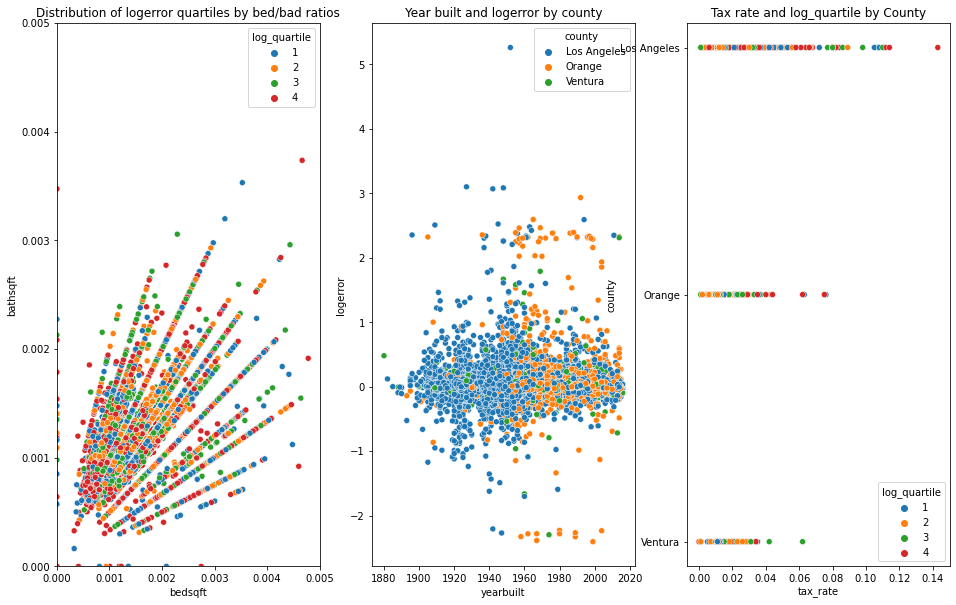

In [134]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.bedsqft, y=train.bathsqft, hue=train.log_quartile)
plt.title('Distribution of logerror quartiles by bed/bad ratios')
plt.xlim(0,.005)
plt.ylim(0,.005)
plt.subplot(132)
sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue='county')
plt.title('Year built and logerror by county')
plt.subplot(133)
sns.scatterplot(data=train, x='tax_rate', y='county', hue='log_quartile')
plt.title('Tax rate and log_quartile by County')
plt.show()

***
Key Takeaways: 
* When accounting for size:
    * logerror is greater amongst smaller properties with low bath and bed to sqft ratios
    * additionally, there appears to be a ratio b/w bed/baths & sqft that leads to less logerror as in the dispersion you can see logerror rise as the ratio b/w the two gets skewed one way or the other
    * logerror appears to rise as bed/bath ratios expand
* When accounting for yearbuilt:
    * logerror appears in Los Angeles county appears to greater under 1960 whild Orange county logerrors appear to account for most of the logerror after 1960
* When accounting for tax_rate:
    * logerror appears to rise as tax_rates rise in Orange and Los Angeles Counties
***

## Distribution of logerror of logerror and bed/bath sqft ratios, yearbuilt & county by market segment

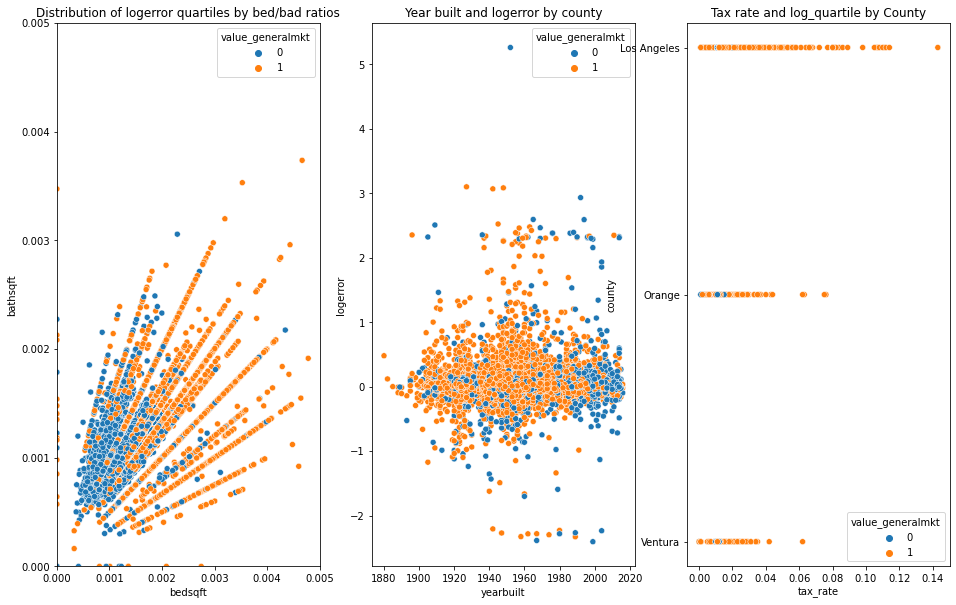

In [135]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.bedsqft, y=train.bathsqft, hue=train.value_generalmkt)
plt.title('Distribution of logerror quartiles by bed/bad ratios')
plt.xlim(0,.005)
plt.ylim(0,.005)
plt.subplot(132)
sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue=train.value_generalmkt)
plt.title('Year built and logerror by county')
plt.subplot(133)
sns.scatterplot(data=train, x='tax_rate', y='county', hue=train.value_generalmkt)
plt.title('Tax rate and log_quartile by County')
plt.show()

***
Key Takeaways: 
* Breaking the data into a general and premium market:
    * illustrates that logerror is greater in lower bed/bath per sqft ratios is associated with the fact that the houses are in the premium market suggesting sqft is higher
    * shows that logerror in Los Angeles county is more associatd with age than by market segment while log error in Orange County primarily fueled by the premium market
***

## Cross comparison of market segment, loq_quartile distribution & yearbuilt by longitude/latitude

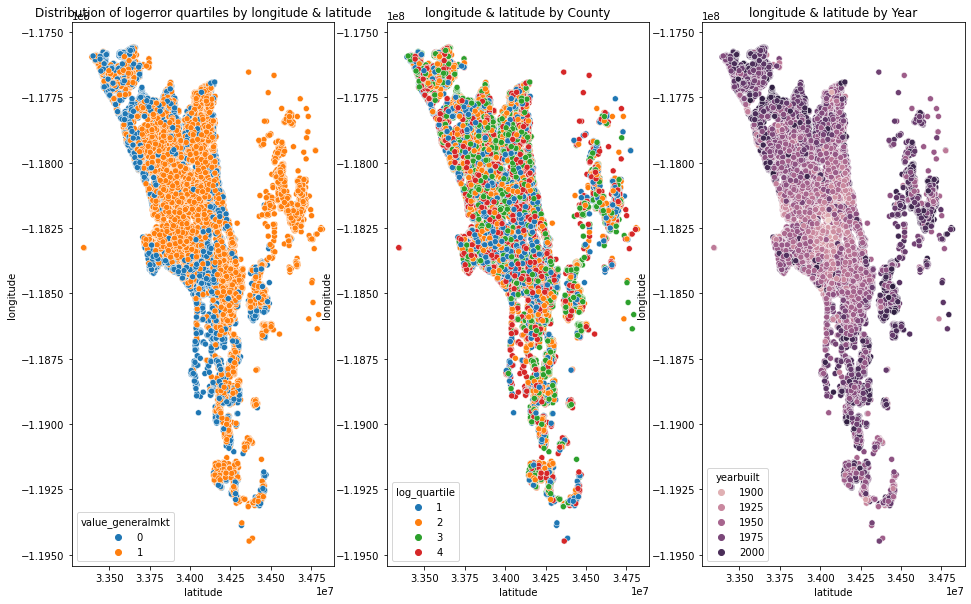

In [136]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.value_generalmkt)
plt.title('Distribution of logerror quartiles by longitude & latitude')
plt.subplot(132)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.log_quartile)
plt.title('longitude & latitude by County')
plt.subplot(133)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.yearbuilt)
plt.title('longitude & latitude by Year')
plt.show()

***
Key Takeaways: 
* Breaking the data into a general and premium market by location:
    * we see that the premium market looks to have a higher correlation with logerror
        * premium maket in Los Angeles is older while Orange County much newer
***

## Hypothesis Testing

$H_0$: There is no correlation between bedsqft and logerror (independent)

$H_a$: The is some correlation between bedsqft and logerror (dependent)

alpha = 0.05

In [215]:
stats.ttest_ind(train.bedsqft, train.logerror)

Ttest_indResult(statistic=-17.129784043757173, pvalue=1.2842690205302469e-65)

In [216]:
corr, p = stats.pearsonr(train.bedsqft, train.logerror)
corr, p

(-0.011242235793329315, 0.05375153320088318)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between bedsqft and logerror (this one is close enough to alpha I'm gonna let slide)
</div>

$H_0$: There is no correlation between bathsqft and logerror (independent)

$H_a$: The is some correlation between bathsqft and logerror (dependent)

alpha = 0.05

In [217]:
stats.ttest_ind(train.bathsqft, train.logerror)

Ttest_indResult(statistic=-17.766417884825273, pvalue=1.9663140455898716e-70)

In [218]:
corr, p = stats.pearsonr(train.bathsqft, train.logerror)
corr, p

(-0.00810131013463549, 0.16455228569418137)

##### <div class="alert alert-block alert-danger">We can not reject the null hypothesis and confirm that there is a statistically significant correlation between bedsqft and logerror. 
</div>

$H_0$: There is no correlation between age and logerror (independent)

$H_a$: The is some correlation between age and logerror (dependent)

alpha = 0.05

In [219]:
stats.ttest_ind(train.age, train.logerror)

Ttest_indResult(statistic=398.117275173925, pvalue=0.0)

In [220]:
corr, p = stats.pearsonr(train.age, train.logerror)
corr, p

(-0.02195073757917766, 0.00016559920916268798)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between age and logerror
</div>

$H_0$: There is no correlation between tax_rate and logerror (independent)

$H_a$: The is some correlation between tax_rate and logerror (dependent)

alpha = 0.05

In [221]:
stats.ttest_ind(train.tax_rate, train.logerror)

Ttest_indResult(statistic=-6.34285258347988, pvalue=2.2718093121733533e-10)

In [222]:
corr, p = stats.pearsonr(train.tax_rate, train.logerror)
corr, p

(0.010026797707469469, 0.0853798584141799)

##### <div class="alert alert-block alert-danger">We can not reject the null hypothesis and confirm that there is a statistically significant correlation between tax_rate and logerror
</div>

$H_0$: There is no correlation between value_generalmkt and logerror (independent)

$H_a$: The is some correlation between value_generalmkt and logerror (dependent)

alpha = 0.05

In [228]:
stats.ttest_ind(train.value_generalmkt, train.logerror)

Ttest_indResult(statistic=266.666693714637, pvalue=0.0)

In [227]:
corr, p = stats.pearsonr(train.value_generalmkt, train.logerror)
corr, p

(-0.00307172725966356, 0.5981924150363455)

##### <div class="alert alert-block alert-danger">We can not reject the null hypothesis and confirm that there is a statistically significant correlation between value_generalmkt and logerror
</div>

$H_0$: There is no correlation between county and logerror (independent)

$H_a$: The is some correlation between county and logerror (dependent)

alpha = 0.05

In [225]:
stats.ttest_ind(train_scaled.county, train.logerror)

Ttest_indResult(statistic=336.3836901887968, pvalue=0.0)

In [226]:
corr, p = stats.pearsonr(train_scaled.county, train.logerror)
corr, p

(0.02028691753536657, 0.0004997688060568025)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between county and logerror
</div>

***
Takeaways: 
* Interestingly, my engineered features combining bath/bed with sqft differed in significance w/bathsqft not having enough statistical significance
* County as an independent feature is correlatedt. As we saw during exploration, when combined with independent features, it adds explanatory power
* My engineered feature separating the market into general and premium on its own wasn't statistically correlated with logerror.  However, during exploration, we saw that it may warrant consideration in clusters with other that are
* Statistical testing showed that tax_rate was not a significant logerror driver
***

# Clusters

In [286]:
X = train_scaled[['latitude', 'longitude', 'value_generalmkt']]
Xv = validate_scaled[['latitude', 'longitude', 'value_generalmkt']]
Xt = test_scaled[['latitude', 'longitude', 'value_generalmkt']]

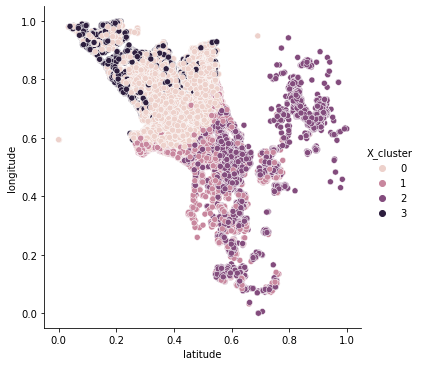

In [287]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.fit(Xv)
kmeans.fit(Xt)
train_scaled['X_cluster'] = kmeans.predict(X)
validate_scaled['X_cluster'] = kmeans.predict(Xv)
test_scaled['X_cluster'] = kmeans.predict(Xt)

sns.relplot(data=train_scaled, x='latitude', y='longitude', hue='X_cluster')

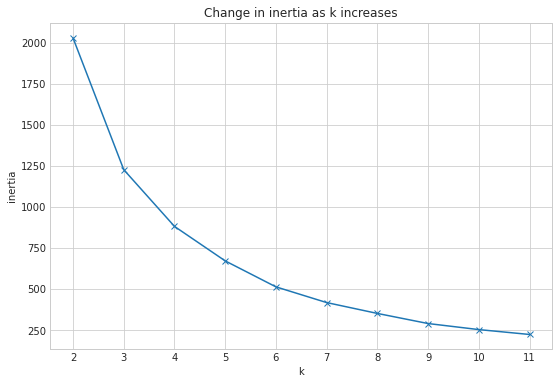

In [288]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

$H_0$: There is no correlation between X_cluster and logerror (independent)

$H_a$: The is some correlation between X_cluster and logerror (dependent)

alpha = 0.05

In [289]:
stats.ttest_ind(train_scaled.X_cluster, train_scaled.logerror)

Ttest_indResult(statistic=158.14075133247727, pvalue=0.0)

In [290]:
corr, p = stats.pearsonr(train_scaled.X_cluster, train_scaled.logerror)
corr, p

(0.01140291798763848, 0.05041762989343866)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between X_cluster and logerror
</div>

In [234]:
Y = train_scaled[['bathsqft', 'bedsqft', 'value_generalmkt']]
Yv = validate_scaled[['bathsqft', 'bedsqft', 'value_generalmkt']]
Yt = test_scaled[['bathsqft', 'bedsqft', 'value_generalmkt']]

(0.0, 0.3)

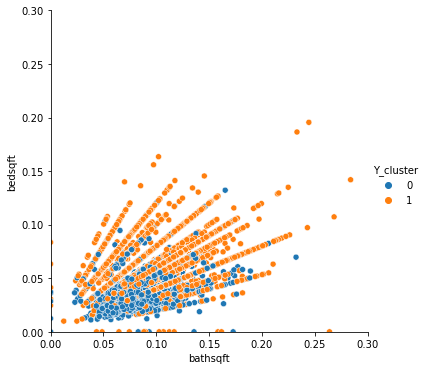

In [235]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(Y)
kmeans.fit(Yv)
kmeans.fit(Yt)
train_scaled['Y_cluster'] = kmeans.predict(Y)
validate_scaled['Y_cluster'] = kmeans.predict(Yv)
test_scaled['Y_cluster'] = kmeans.predict(Yt)

sns.relplot(data=train_scaled, x='bathsqft', y='bedsqft', hue='Y_cluster')
plt.xlim(0,.3)
plt.ylim(0,.3)

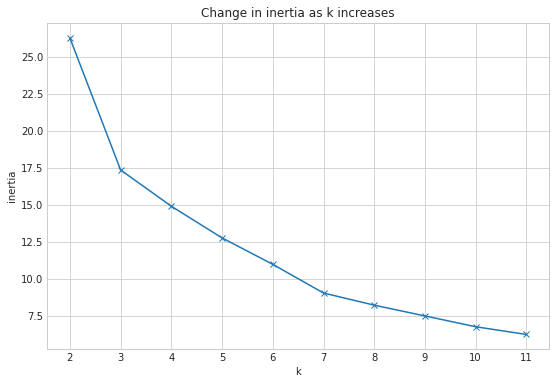

In [236]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(Y).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

$H_0$: There is no correlation between Y_cluster and logerror (independent)

$H_a$: The is some correlation between Y_cluster and logerror (dependent)

alpha = 0.05

In [237]:
stats.ttest_ind(train_scaled.Y_cluster, train_scaled.logerror)

Ttest_indResult(statistic=266.666693714637, pvalue=0.0)

In [238]:
corr, p = stats.pearsonr(train_scaled.Y_cluster, train_scaled.logerror)
corr, p

(-0.00307172725966356, 0.5981924150363455)

##### <div class="alert alert-block alert-danger">We can not reject the null hypothesis and confirm that there is a statistically significant correlation between Y_cluster and logerror
</div>

In [239]:
Z = train_scaled[['age', 'value_generalmkt']]
Zv = validate_scaled[['age', 'value_generalmkt']]
Zt = test_scaled[['age', 'value_generalmkt']]

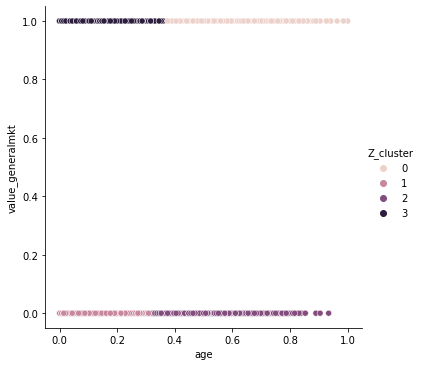

In [240]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(Z)
kmeans.fit(Zv)
kmeans.fit(Zt)

train_scaled['Z_cluster'] = kmeans.predict(Z)
validate_scaled['Z_cluster'] = kmeans.predict(Zv)
test_scaled['Z_cluster'] = kmeans.predict(Zt)

sns.relplot(data=train_scaled, x='age', y='value_generalmkt', hue='Z_cluster')

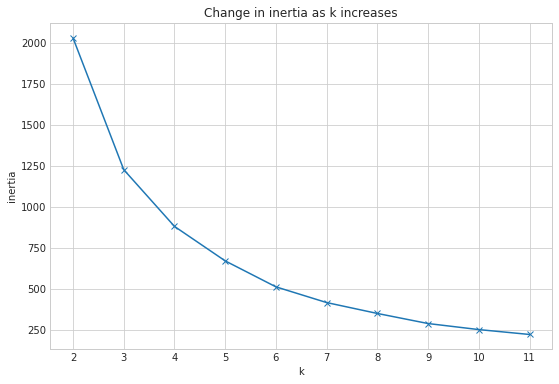

In [249]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

$H_0$: There is no correlation between Z_cluster and logerror (independent)

$H_a$: The is some correlation between Z_cluster and logerror (dependent)

alpha = 0.05

In [250]:
stats.ttest_ind(train_scaled.Z_cluster, train_scaled.logerror)

Ttest_indResult(statistic=147.6228819667657, pvalue=0.0)

In [263]:
corr, p = stats.pearsonr(train_scaled.Z_cluster, train_scaled.logerror)
corr, p

(-0.007104142291330891, 0.222906242877856)

##### <div class="alert alert-block alert-danger">We can not reject the null hypothesis and confirm that there is a statistically significant correlation between Z_cluster and logerror
</div>

In [257]:
W = train_scaled[['tax_rate', 'age']]
Wv = validate_scaled[['tax_rate', 'age']]
Wt = test_scaled[['tax_rate', 'age']]

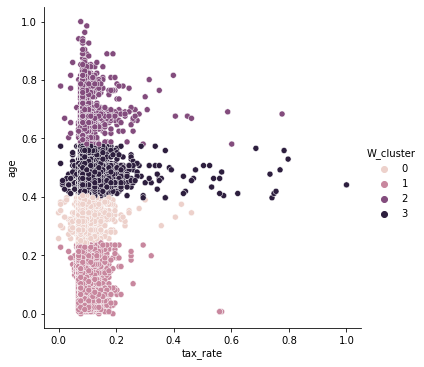

In [258]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(W)
kmeans.fit(Wv)
kmeans.fit(Wt)

train_scaled['W_cluster'] = kmeans.predict(W)
validate_scaled['W_cluster'] = kmeans.predict(Wv)
test_scaled['W_cluster'] = kmeans.predict(Wt)

sns.relplot(data=train_scaled, x='tax_rate', y='age', hue='W_cluster')

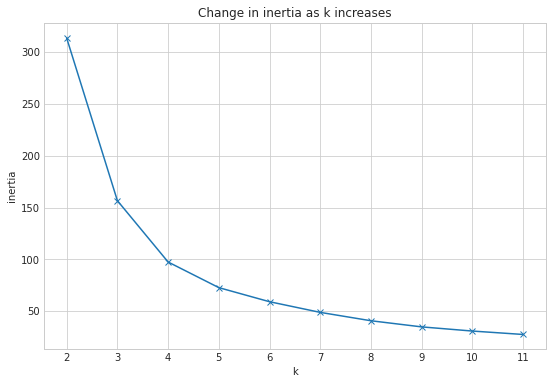

In [259]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(W).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

$H_0$: There is no correlation between W_cluster and logerror (independent)

$H_a$: The is some correlation between W_cluster and logerror (dependent)

alpha = 0.05

In [260]:
stats.ttest_ind(train_scaled.W_cluster, train_scaled.logerror)

Ttest_indResult(statistic=215.8931413417587, pvalue=0.0)

In [262]:
corr, p = stats.pearsonr(train_scaled.W_cluster, train_scaled.logerror)
corr, p

(-0.015453373347090339, 0.00801555024588777)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between W_cluster and logerror
</div>

In [264]:
V = train_scaled[['latitude', 'longitude', 'age']]
Vv = validate_scaled[['latitude', 'longitude', 'age']]
Vt = test_scaled[['latitude', 'longitude', 'age']]

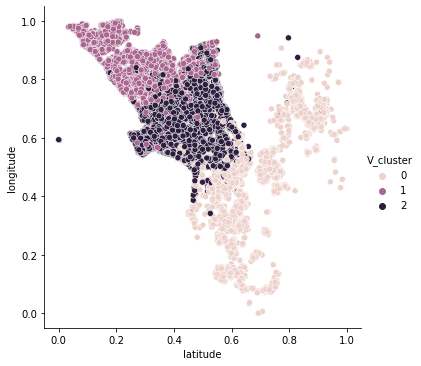

In [265]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(V)
kmeans.fit(Vv)
kmeans.fit(Vt)
train_scaled['V_cluster'] = kmeans.predict(V)
validate_scaled['V_cluster'] = kmeans.predict(Vv)
test_scaled['V_cluster'] = kmeans.predict(Vt)

sns.relplot(data=train_scaled, x='latitude', y='longitude', hue='V_cluster')

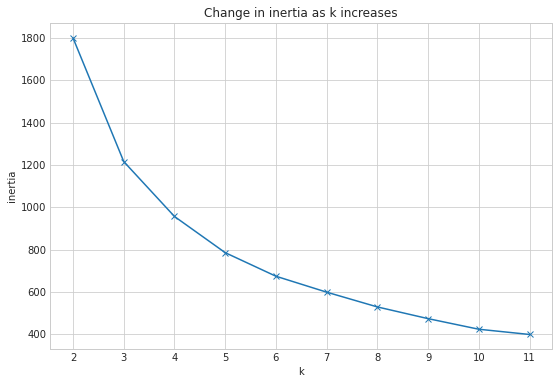

In [266]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(V).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

$H_0$: There is no correlation between V_cluster and logerror (independent)

$H_a$: The is some correlation between V_cluster and logerror (dependent)

alpha = 0.05

In [267]:
stats.ttest_ind(train_scaled.V_cluster, train_scaled.logerror)

Ttest_indResult(statistic=232.03148793404097, pvalue=0.0)

In [268]:
corr, p = stats.pearsonr(train_scaled.V_cluster, train_scaled.logerror)
corr, p

(-0.01927099973318468, 0.0009445811339528957)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between V_cluster and logerror
</div>

***
Takeaways: 
* 3 out of the 5 clusters using statistically correlated features were also statistically correlated with logerror [X_cluster, Y_cluster, V_cluster]
    * Interestingly, \market segment did add predictive value when clustered with geolocation
    * Additionally, tax_rate by age had some very clear clusters, and was a statisically significant driver
    * Geolocation by age was statistically correlated
        * The clusters don't fully conform to the county boundaries but this is influenced by age and intra-county development.  Considering age is a strong driver, I believe the clusters are capturing dynamics that county restrictions miss 
            * I expect the clusters are capturing some of the more recent build out in Los Angeles County which is helpful as the there is significant correlation with our target in the older areas of the City (as evidenced in the exploratory charts)
***

In [183]:
train_scaled.columns

Index(['calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'taxvaluedollarcnt', 'tax_rate', 'bedsqft', 'bathsqft', 'pricesqft',
       'age', 'logerror', 'log_quartile', 'value_generalmkt', 'county',
       'X_cluster', 'Y_cluster', 'Z_cluster', 'W_cluster', 'V_cluster'],
      dtype='object')

# Models

### Feature Selection - only utilizing clusters

In [321]:
# selected features
selected_features = ['V_cluster', 'X_cluster']

### X, Y splits

In [322]:
# X Y splits
X_train, y_train = train_scaled[selected_features], train_scaled.logerror
X_validate, y_validate = validate_scaled[selected_features], validate_scaled.logerror
X_test, y_test = test_scaled[selected_features], test_scaled.logerror

## Baseline

In [323]:
# create dataframes out of my y dataframes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# Baseline calc
pred_mean = y_train['logerror'].mean()
y_train['pred_mean'] = pred_mean
y_validate['pred_mean'] = pred_mean


# 3. RMSE of log error mean
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_mean)**(1/2)


print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.18 
Validate/Out-of-Sample:  0.18


## OLS Regression Model

In [324]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.logerror)

# predict train
y_train['pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm)**(1/2)

# predict validate
y_validate['pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.18098389469096168 
Validation/Out-of-Sample:  0.1782829773625227


## LARS LASSO Regression Model

In [325]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.logerror)

# predict train
y_train['pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lars)**(1/2)

# predict validate
y_validate['pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.18101844427955646 
Validation/Out-of-Sample:  0.1782898392522853


## Polynomial Regression

In [326]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [327]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm2)**(1/2)

# predict validate
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.18085748941401647 
Validation/Out-of-Sample:  0.1781687912239941


In [328]:
## Model selection and test

In [330]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2, y_test.logerror)

# predict test
y_test['pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test:  0.16823239839750648


***
Model Results: 
* Model Selection: Polynomial Regressor slightly outperformed others (basically equivalent) on the Out-of-sample RMSE 
    * Model Test RMSE results actually improved from 0.178 to 0.168... vs 0.18 Benchmark
* Model iterations included all clusters, individual clusters and clusters with additional features
    * The models largely met the Benchmark and slightly outperformed based on RMSE 
    * I was able to marginally improve model performance by continually adding more and more features but for the most part the clusters alone did a good job of capturing most predictive value add
    * Adjustment of hyperparameters such as Polynomial degrees had no significant impact
    
Conclusion:
* Geolocation and Age independently were the biggest drivers to come out of my exploration and modeling
    * I had expected sqft/bed/baths to also prove out but my engineered features generating bedsqft & bathsqft ratios didn't pass statistical testing
* I believe that the level of granularity necessary to significantly outperform the Benchmark was outside the scope of this exercise.
    * I believe geolocation is a major explanatory variable and chose to focus my efforts at the County level.  I believe, a more localized approach (e.g. City, Neighborhood) could lead to better results and better account for factors like age and market segments
* My expectation was that I'd be able to add predictive value by sorting the data out into two markets. In exploration, it looked like I was on to something and it panned out in the hypothesis testing and modeling.
    * One of the clusters I utilized focused on mapping geolocation by market segment
* I believe by segmenting the market like this and coupling with a cluster focused on age I was able to explain a large portion of what is driving logerror in the Zillow model
  
Next Steps:
* I remain convinced I was on to something and assume that the contradicting information by County may have created some noise.  E.G. market segmentation and age weren't consistent between Counties and even intra-County.
    * In my next steps, I would make an effort to parse geolocation in greater detail than the County level wiith the expectation that the level of granularity could yield better results
***